<a href="https://colab.research.google.com/github/JayPBhatia/MastersProject/blob/main/SmartGrid_ADSC_16850_DataSet_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [ ]:
#connect to G Drive 
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
import numpy as np
from numpy import array
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from scipy.stats import norm
from sklearn.metrics import mean_squared_error
import statistics

In [ ]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print(tf.keras.__version__)
print(tf.__version__)

2.7.0
2.7.0


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
import tensorflow_probability as tfp
tfd = tfp.distributions

## DataSet

TODO : load and process pcapng. instead of CSV to get more features /Normal/Variable_Loading/VariableLoad.pcapng


In [ ]:
dataset_url = "https://raw.githubusercontent.com/smartgridadsc/IEC61850SecurityDataset/master/Disturbance/Breaker%20Failure/csv//BIED100.csv"
df1 = pd.read_csv(dataset_url)
df1

,Circuit breaker Open/Close Status,Disconnector Open/Close Status,Earth switch Open/Close Status,Protection system healthy (Trip circuit healthy),Control level - Local or remote,Protection tripped,Circuit breaker mechanical failure,Auxiliary power failure,Current Line 'L1',Current Line 'L2',Current Line 'L3',Voltage Phase 'L1-N',Voltage Phase 'L2-N',Voltage Phase 'L3-N',Frequency,Power Factor
0,0,1,0,1,False,False,1,False,1,5,-4,38097,38094,38110,49.96,0.86
1,0,1,0,1,False,False,1,False,0,1,1,38096,38120,38104,49.99,0.87
2,0,1,0,1,False,False,1,False,2,0,3,38098,38112,38108,49.98,0.86
3,0,1,0,1,False,False,1,False,-5,-1,3,38101,38095,38120,50.03,0.87
4,0,1,0,1,False,False,1,False,-4,-1,-4,38092,38115,38090,50.01,0.83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0,1,0,1,False,True,1,False,5,4,-2,38100,38098,38095,49.95,0.84
596,0,1,0,1,False,True,1,False,1,4,-3,38120,38090,38118,50.02,0.86
597,0,1,0,1,False,True,1,False,-1,-4,3,38092,38104,38100,49.97,0.86
598,0,1,0,1,False,True,1,False,2,-4,-5,38104,38091,38110,50.02,0.86


In [ ]:
df1 = df1.iloc[:, 8:]

## Exploratory Data Analysis (EDA)

In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0    Current Line 'L1'     600 non-null    int64  
 1    Current Line 'L2'     600 non-null    int64  
 2    Current Line 'L3'     600 non-null    int64  
 3    Voltage Phase 'L1-N'  600 non-null    int64  
 4    Voltage Phase 'L2-N'  600 non-null    int64  
 5    Voltage Phase 'L3-N'  600 non-null    int64  
 6    Frequency             600 non-null    float64
 7    Power Factor          600 non-null    float64
dtypes: float64(2), int64(6)
memory usage: 37.6 KB


In [ ]:
df1.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Current Line 'L1',600.0,-0.135000,3.177042,-5.00,-3.00,0.00,3.00,5.00
Current Line 'L2',600.0,0.066667,3.161574,-5.00,-3.00,0.00,3.00,5.00
Current Line 'L3',600.0,-0.125000,3.176401,-5.00,-3.00,0.00,3.00,5.00
Voltage Phase 'L1-N',600.0,38104.740000,8.895183,38090.00,38098.00,38104.00,38112.00,38120.00
Voltage Phase 'L2-N',600.0,38105.263333,9.148961,38090.00,38097.00,38105.00,38113.00,38120.00
Voltage Phase 'L3-N',600.0,38104.546667,9.258547,38090.00,38097.00,38104.00,38113.00,38120.00
Frequency,600.0,50.001350,0.031943,49.95,49.97,50.00,50.03,50.05
Power Factor,600.0,0.850483,0.014222,0.83,0.84,0.85,0.86,0.87


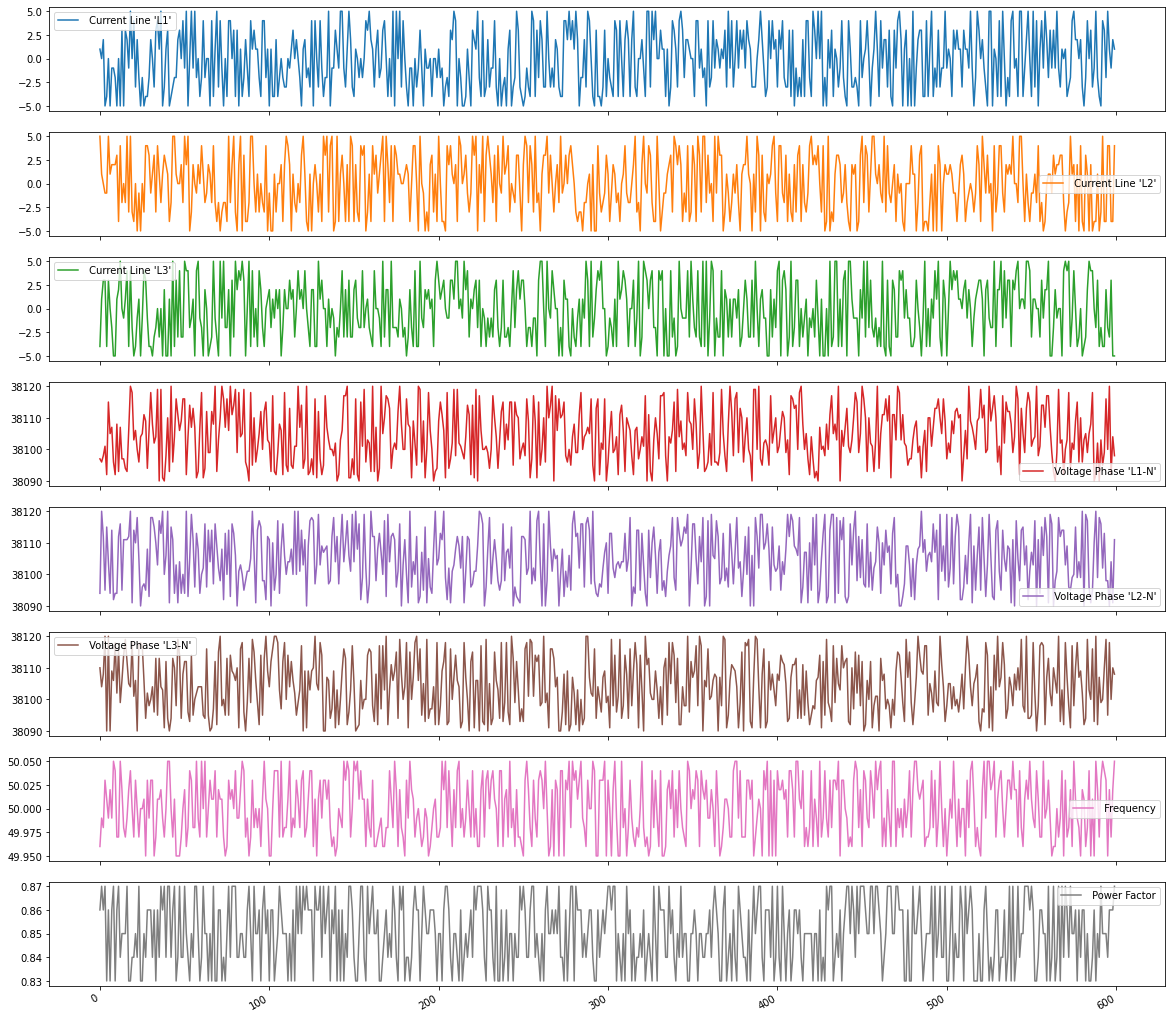

In [ ]:
df1.plot(subplots=True,figsize=(20,20))
plt.show()

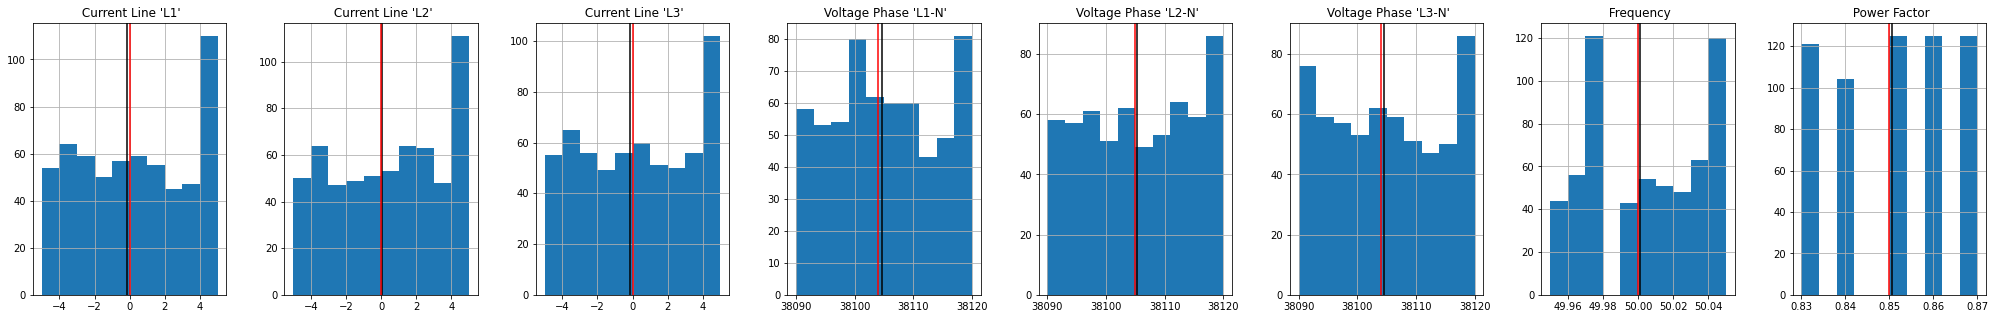

In [ ]:
axes = df1.hist(layout=(1,len(df1.columns)), figsize=(35,5))
for ax, col in zip(axes[0], df1.columns):  # For each column...
    ax.axvline(df1[col].mean(), c='k')  # Plot mean
    ax.axvline(df1[col].median(), c='r')  # Plot median 
plt.show()

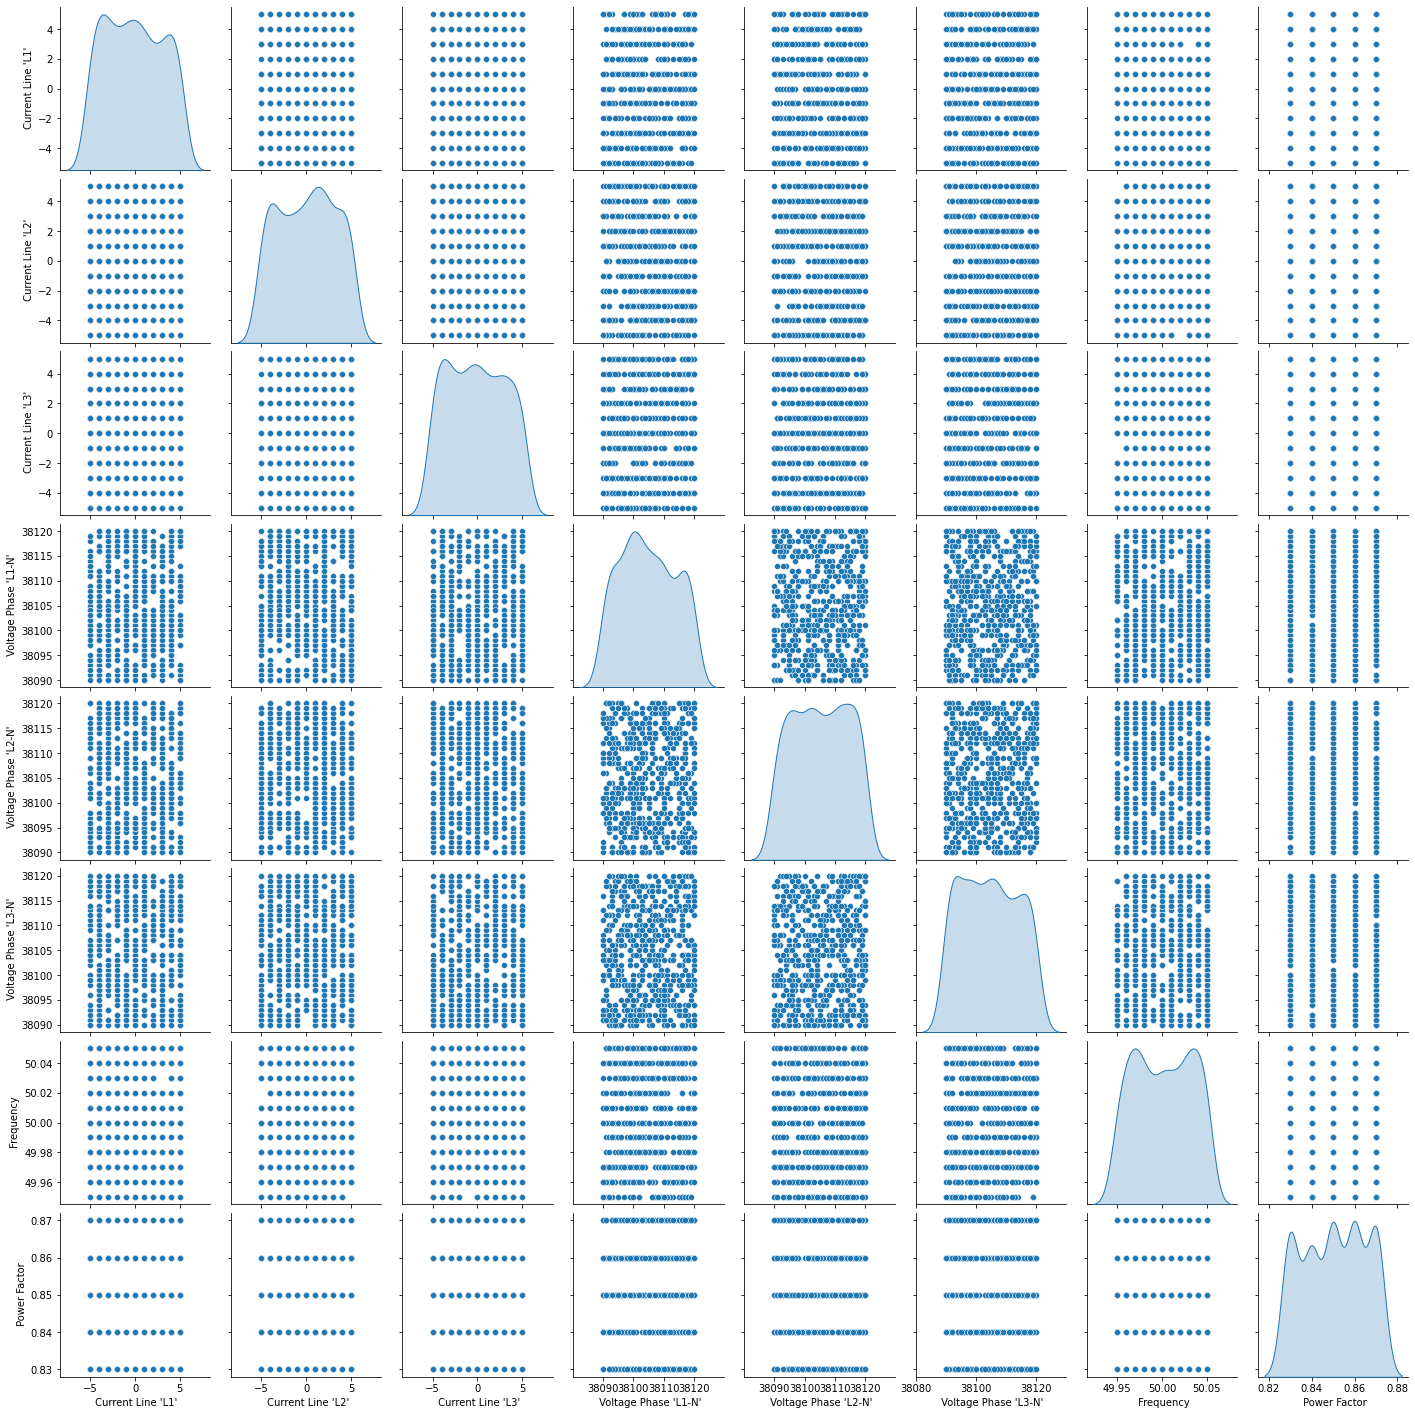

In [ ]:
sns.pairplot(df1, diag_kind='kde')

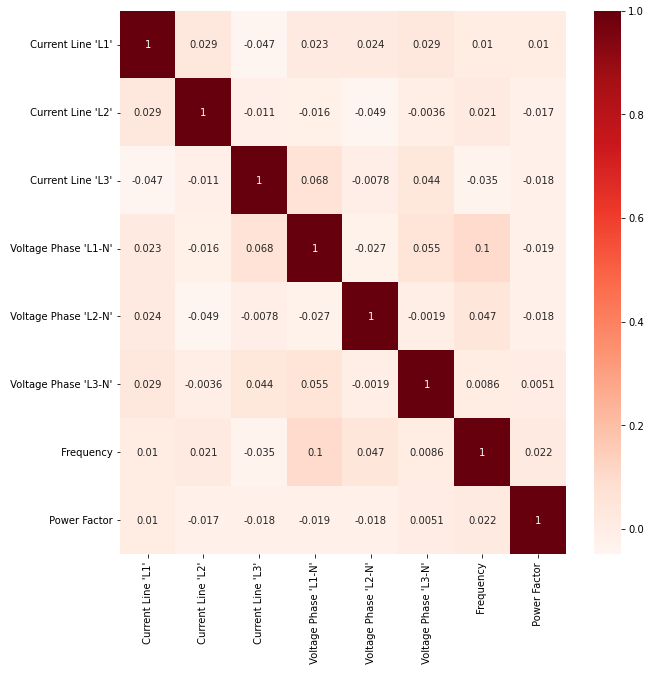

In [ ]:
plt.figure(figsize=(10,10))
cor = df1.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

### Adufller Test

The null hypothesis of the test is that the time series can be represented by a unit root, that it is not stationary (has some time-dependent structure). The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.

Null Hypothesis (H0): If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.


Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure

In [ ]:
def adfuller_test(series, signif=0.05):
  x = adfuller(series, autolag='AIC')
  output = {'Test Statistic': x[0], 
              'P-value': x[1], 
              'Number of lags': x[2], 
              'Number of observations': x[3],
              f'Reject (signif. level {signif})': x[1] < signif }
              
  for key, val in x[4].items():
    output[f'Critical value {key}'] = val
  return pd.Series(output)

df1.apply(lambda x: adfuller_test(x), axis=0)

,Current Line 'L1',Current Line 'L2',Current Line 'L3',Voltage Phase 'L1-N',Voltage Phase 'L2-N',Voltage Phase 'L3-N',Frequency,Power Factor
Test Statistic,-10.4646,-18.2622,-24.9584,-24.363,-26.3208,-26.0129,-23.4945,-24.0285
P-value,1.33191e-18,2.32969e-30,0,0,0,0,0,0
Number of lags,5,1,0,0,0,0,0,0
Number of observations,594,598,599,599,599,599,599,599
Reject (signif. level 0.05),True,True,True,True,True,True,True,True
Critical value 1%,-3.44141,-3.44133,-3.44131,-3.44131,-3.44131,-3.44131,-3.44131,-3.44131
Critical value 5%,-2.86642,-2.86639,-2.86638,-2.86638,-2.86638,-2.86638,-2.86638,-2.86638
Critical value 10%,-2.56937,-2.56935,-2.56935,-2.56935,-2.56935,-2.56935,-2.56935,-2.56935


p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

The more negative test statistic, the stronger the rejection of the hypothesis that there is a unit root at some level of confidence

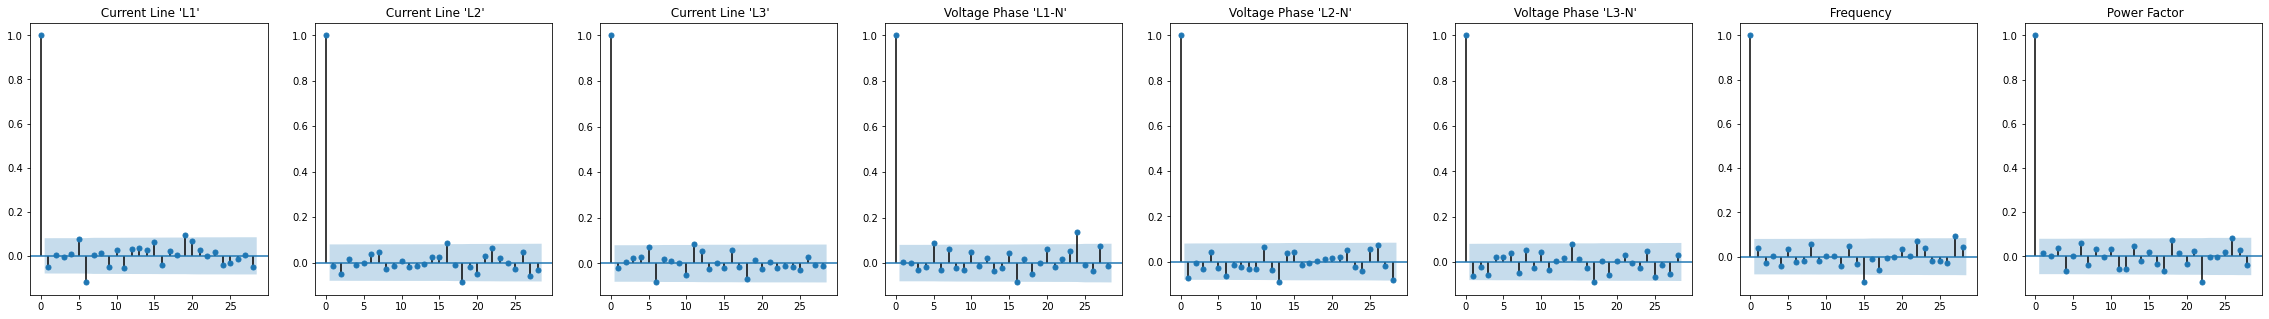

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=len(df1.columns),figsize=(40,5))
for col, axe in zip(df1.columns,axes):
    plot_acf(df1[col], title=col, ax=axe);

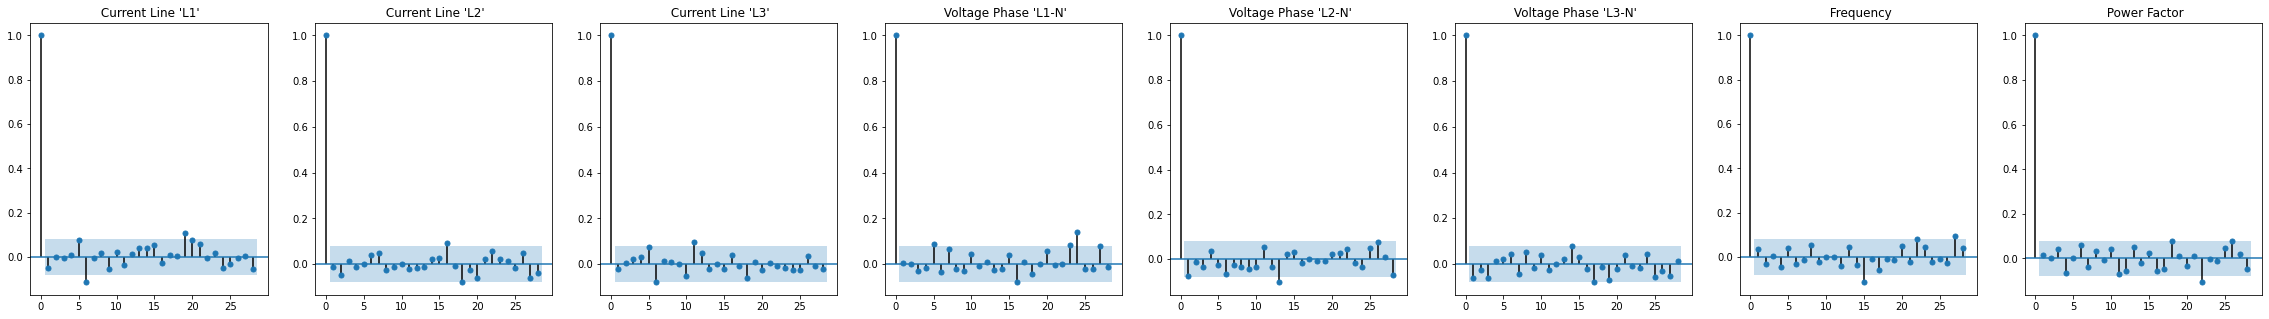

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=len(df1.columns),figsize=(40,5))
for col, axe in zip(df1.columns,axes):
    plot_pacf(df1[col], title=col, ax=axe);

## Data Cleaning 

In [ ]:
df1.isna().sum()

 Current Line 'L1'       0
 Current Line 'L2'       0
 Current Line 'L3'       0
 Voltage Phase 'L1-N'    0
 Voltage Phase 'L2-N'    0
 Voltage Phase 'L3-N'    0
 Frequency               0
 Power Factor            0
dtype: int64

## Data Engineering

## Data Normalization 

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df1_scaled = pd.DataFrame(scaler.fit_transform(df1), columns=df1.columns)
df1_scaled

,Current Line 'L1',Current Line 'L2',Current Line 'L3',Voltage Phase 'L1-N',Voltage Phase 'L2-N',Voltage Phase 'L3-N',Frequency,Power Factor
0,0.6,1.0,0.1,0.233333,0.133333,0.666667,0.1,0.75
1,0.5,0.6,0.6,0.200000,1.000000,0.466667,0.4,1.00
2,0.7,0.5,0.8,0.266667,0.733333,0.600000,0.3,0.75
3,0.0,0.4,0.8,0.366667,0.166667,1.000000,0.8,1.00
4,0.1,0.4,0.1,0.066667,0.833333,0.000000,0.6,0.00
...,...,...,...,...,...,...,...,...
595,1.0,0.9,0.3,0.333333,0.266667,0.166667,0.0,0.25
596,0.6,0.9,0.2,1.000000,0.000000,0.933333,0.7,0.75
597,0.4,0.1,0.8,0.066667,0.466667,0.333333,0.2,0.75
598,0.7,0.1,0.0,0.466667,0.033333,0.666667,0.7,0.75


## LSTM Parallel Multi 

### Data Split 

In [ ]:
column_indices = {name: i for i, name in enumerate(df1_scaled.columns)}
n = len(df1_scaled)
train_df = df1_scaled[0:int(n*0.7)]
val_df = df1_scaled[int(n*0.7):int(n*0.9)]
test_df = df1_scaled[int(n*0.9):]


In [ ]:
time_step = 2
EVALUATION_INTERVAL = 100
EPOCHS = 200
batch_size  = 10
buffer_size = 100

In [ ]:
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 

X_train_multi, y_train_multi = split_sequences(train_df.to_numpy(), time_step)
X_val_multi, y_val_multi = split_sequences(val_df.to_numpy(), time_step)
X_test_multi, y_test_multi = split_sequences(test_df.to_numpy(), time_step)

In [ ]:

multi_model = Sequential()
multi_model.add(LSTM(10, activation='relu', input_shape=(X_train_multi.shape[1],X_train_multi.shape[-1]),recurrent_dropout=0.1, dropout=0.1))
multi_model.add(Dense(y_train_multi.shape[-1]))
#multi_model.add(tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1)))
multi_model.compile(optimizer='adam', loss='mse', metrics=['mean_squared_error'])

### Train and Test

In [ ]:
train_data_multi = tf.data.Dataset.from_tensor_slices((X_train_multi,y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(buffer_size).batch(batch_size).repeat()
val_data_multi = tf.data.Dataset.from_tensor_slices((X_val_multi,y_val_multi))
val_data_multi = val_data_multi.batch(batch_size).repeat()

In [ ]:
history_multi = multi_model.fit(train_data_multi, epochs = EPOCHS,
              steps_per_epoch = EVALUATION_INTERVAL,
                     validation_data = val_data_multi,
                     validation_steps = 25, verbose=1)

Epoch 1/200
100/100 [==============================] - 4s 7ms/step - loss: 0.2244 - mean_squared_error: 0.2244 - val_loss: 0.1301 - val_mean_squared_error: 0.1301
Epoch 2/200
100/100 [==============================] - 0s 4ms/step - loss: 0.1175 - mean_squared_error: 0.1175 - val_loss: 0.1137 - val_mean_squared_error: 0.1137
Epoch 3/200
100/100 [==============================] - 0s 4ms/step - loss: 0.1116 - mean_squared_error: 0.1116 - val_loss: 0.1110 - val_mean_squared_error: 0.1110
Epoch 4/200
100/100 [==============================] - 0s 4ms/step - loss: 0.1095 - mean_squared_error: 0.1095 - val_loss: 0.1090 - val_mean_squared_error: 0.1090
Epoch 5/200
100/100 [==============================] - 0s 4ms/step - loss: 0.1067 - mean_squared_error: 0.1067 - val_loss: 0.1071 - val_mean_squared_error: 0.1071
Epoch 6/200
100/100 [==============================] - 0s 4ms/step - loss: 0.1062 - mean_squared_error: 0.1062 - val_loss: 0.1059 - val_mean_squared_error: 0.1059
Epoch 7/200
100/100 [=

### Model Parameter Tuning

### Result

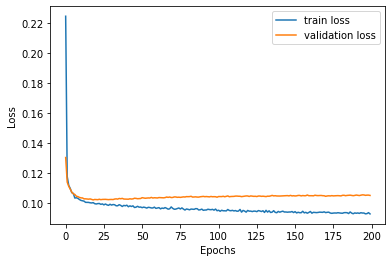

In [ ]:
plt.plot(history_multi.history['loss'],
           label = 'train loss')
plt.plot(history_multi.history['val_loss'],
           label = 'validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

In [ ]:
X_test_multi.shape

(58, 2, 8)

In [ ]:
test_predict_multi=multi_model.predict(X_test_multi)

In [ ]:
test_predict_multi.shape

(58, 8)

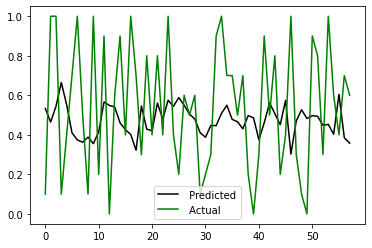

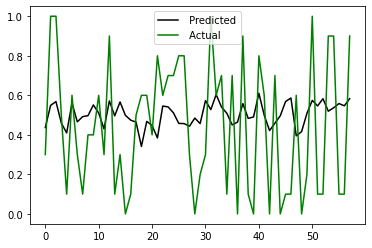

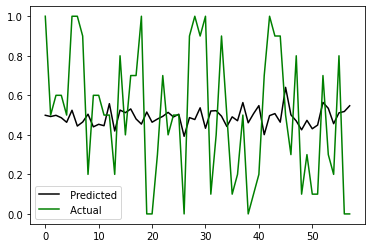

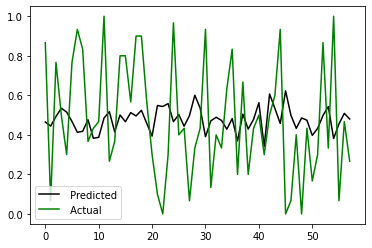

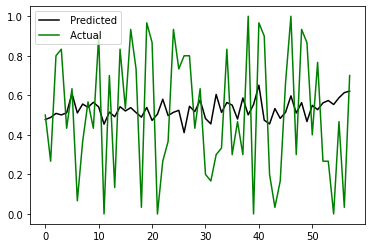

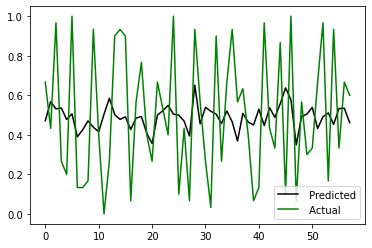

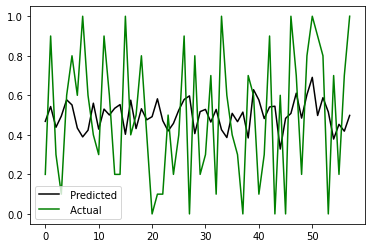

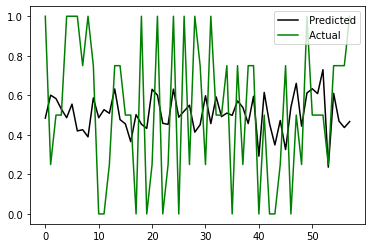

In [ ]:
for i in range(test_predict_multi.shape[1]):
  plt.plot(test_predict_multi[:,i], color = 'black', label = ' Predicted')
  plt.plot(y_test_multi[:,i], color = 'green', label = ' Actual')
  plt.legend()
  plt.show()

In [ ]:
result  =  multi_model.evaluate(x=X_test_multi,y=y_test_multi)
result

2/2 [==============================] - 0s 8ms/step - loss: 0.1099 - mean_squared_error: 0.1099


[0.10993821173906326, 0.10993821173906326]

# gaussian process


In [ ]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

In [ ]:
train_df

,Current Line 'L1',Current Line 'L2',Current Line 'L3',Voltage Phase 'L1-N',Voltage Phase 'L2-N',Voltage Phase 'L3-N',Frequency,Power Factor
0,0.6,1.0,0.1,0.233333,0.133333,0.666667,0.1,0.75
1,0.5,0.6,0.6,0.200000,1.000000,0.466667,0.4,1.00
2,0.7,0.5,0.8,0.266667,0.733333,0.600000,0.3,0.75
3,0.0,0.4,0.8,0.366667,0.166667,1.000000,0.8,1.00
4,0.1,0.4,0.1,0.066667,0.833333,0.000000,0.6,0.00
...,...,...,...,...,...,...,...,...
415,0.7,0.7,0.2,0.600000,0.200000,0.700000,0.9,0.00
416,0.1,0.3,0.4,0.333333,0.566667,0.166667,0.1,0.50
417,0.9,0.2,0.6,0.500000,0.566667,0.633333,0.3,0.50
418,0.9,0.4,0.0,0.233333,0.033333,0.300000,0.1,0.50


In [ ]:
train_df[train_df.columns[0]]

0      0.6
1      0.5
2      0.7
3      0.0
4      0.1
      ... 
415    0.7
416    0.1
417    0.9
418    0.9
419    0.3
Name:  Current Line 'L1', Length: 420, dtype: float64

In [ ]:
# Instantiate a Gaussian Process model
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)